In [1]:
import sys
from importlib import reload
sys.path.append("..")

from scene_description import model, data_utils, global_vars

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split

import json
from datetime import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [3]:
torch.cuda.set_device(1)

In [4]:
mappings_path = "../../qa_data/mappings.json"
processed_data_path = "../../qa_data/processed_data.json"
map_images_path = "../../qa_data/"

In [5]:
mappings = json.load(open(mappings_path))
qa_data = json.load(open(processed_data_path))["data"]

In [6]:
train_data, test_data = train_test_split(qa_data, test_size=0.1, random_state=69)

In [7]:
train_dataset = data_utils.SceneDescriptionDataset(train_data, mappings, map_images_path)
test_dataset = data_utils.SceneDescriptionDataset(test_data, mappings, map_images_path)

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=data_utils.collate_fn,
    num_workers=4
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=data_utils.collate_fn,
    num_workers=4
)

In [9]:
sd_model = model.SceneDescription(num_answers=len(mappings["aid_2_answer_vqa"]),
                                              vocab_size=len(mappings["vocab"]["wid_2_word"]))

In [18]:
device="cuda"
sd_model = sd_model.to(device)
num_epochs = 3
optimizer = Adam(sd_model.parameters(), lr=2e-4)

In [25]:
def process_batch(model, data, lossfn_vqa, lossfn_des, train_batch=True):
    
    if train_batch:
        model.train()
    else:
        model.eval()
    
    (questions, imgs), (answers, answers_vqa) = data
    
    # Set apt device
    answers = answers.long().to(device)
    answers_vqa = answers_vqa.long().to(device)
    imgs = imgs.to(device)
    
    if train_batch:
        optimizer.zero_grad() # clear gradients from previous minibatch
        op_vqa, op_des = model(questions, imgs, answers, device=device) # forward pass
    else:
        op_vqa, op_des = model(questions, imgs, device=device, max_len=answers.size(1)) # eval pass
    
    batch_loss_vqa = lossfn_vqa(op_vqa, answers_vqa) # calc vqa loss
    batch_loss_des = lossfn_des(op_des[:, :-1, :].permute(0, 2, 1), answers[:, 1:]) # calc description loss

    total_loss = batch_loss_des + batch_loss_vqa
    
    batch_vqa_acc = (op_vqa.argmax(dim=-1) == answers_vqa).sum() / len(op_vqa)
    
    if train_batch:
        total_loss.backward()
        optimizer.step()
    
    return batch_loss_vqa.item(), batch_loss_des.item(), total_loss.item(), batch_vqa_acc.item()

In [33]:
def train(model, train_dataloader, test_dataloader, optimizer, epochs):
    writer = SummaryWriter(log_dir="../../runs/{}".format(str(datetime.now())))
    
    lossfn_vqa = nn.CrossEntropyLoss()
    lossfn_des = nn.CrossEntropyLoss(ignore_index=global_vars.PAD_IDX)
    
    train_batch_num = val_batch_num = 0
    
    for e in range(epochs):
        train_loop = tqdm(train_dataloader, total=len(train_dataloader), position=0, leave=False)
        val_loop = tqdm(test_dataloader, total=len(test_dataloader), position=0, leave=False)
        
        loss_vqa = 0.
        loss_des = 0.
        loss_total = 0.
        acc_vqa = 0.
        for batch_num, data in enumerate(train_loop):
            
            batch_loss_vqa, batch_loss_des, batch_loss, batch_acc_vqa = process_batch(model, data, lossfn_vqa,
                                                                       lossfn_des, train_batch=True)

            loss_vqa += batch_loss_vqa
            loss_des += batch_loss_des
            loss_total += batch_loss
            acc_vqa += batch_acc_vqa
            
            writer.add_scalar("Loss/train/batch_loss/vqa", batch_loss_vqa, train_batch_num)
            writer.add_scalar("Loss/train/batch_loss/des", batch_loss_des, train_batch_num)
            writer.add_scalar("Loss/train/batch_loss/total", batch_loss, train_batch_num)
            writer.add_scalar("Loss/train/batch_acc/vqa", batch_acc_vqa, train_batch_num)
            
            if (batch_num + 1) % 10 == 0: writer.flush()
            
            train_batch_num += 1
            

            train_loop.set_description("Epoch={}".format(e+1))
            train_loop.set_postfix(vqa_loss=batch_loss_vqa, des_loss=batch_loss_des, total_loss=batch_loss, vqa_acc=batch_acc_vqa)
            
        writer.add_scalar("Loss/train/loss/vqa", loss_vqa, e)
        writer.add_scalar("Loss/train/loss/des", loss_des, e)
        writer.add_scalar("Loss/train/loss/total", loss_total, e)
        writer.add_scalar("Loss/train/acc/vqa", acc_vqa, e)
        writer.flush()
        
        print("Epoch={} train_vqa_loss={} train_des_loss={} train_total_loss={} train_vqa_acc={}".format(e,
                                                                    loss_vqa/len(train_dataloader),
                                                                    loss_des/len(train_dataloader),
                                                                    loss_total/len(train_dataloader),
                                                                    acc_vqa/len(train_dataloader)))
        
        loss_vqa = 0.
        loss_des = 0.
        loss_total = 0.
        acc_vqa = 0.
        for batch_num, data in enumerate(val_loop):
            
            batch_loss_vqa, batch_loss_des, batch_loss, batch_acc_vqa = process_batch(model, data, lossfn_vqa,
                                                                     lossfn_des, train_batch=False)

            loss_vqa += batch_loss_vqa
            loss_des += batch_loss_des
            loss_total += batch_loss
            acc_vqa += batch_acc_vqa
            
            writer.add_scalar("Loss/val/batch_loss/vqa", batch_loss_vqa, val_batch_num)
            writer.add_scalar("Loss/val/batch_loss/des", batch_loss_des, val_batch_num)
            writer.add_scalar("Loss/val/batch_loss/total", batch_loss, val_batch_num)
            writer.add_scalar("Loss/val/batch_acc/vqa", batch_acc_vqa, val_batch_num)
            if (batch_num + 1) % 10 == 0: writer.flush()
            
            val_batch_num += 1

            val_loop.set_description("Epoch={}".format(e+1))
            val_loop.set_postfix(vqa_loss=batch_loss_vqa, des_loss=batch_loss_des, total_loss=batch_loss, vqa_acc=batch_acc_vqa)
        
        writer.add_scalar("Loss/val/loss/vqa", loss_vqa, e)
        writer.add_scalar("Loss/val/loss/des", loss_des, e)
        writer.add_scalar("Loss/val/loss/total", loss_total, e)
        writer.add_scalar("Loss/val/acc/vqa", acc_vqa, e)
        writer.flush()
        
        print("Epoch={} val_vqa_loss={} val_des_loss={} val_total_loss={} val_vqa_acc".format(e,
                                                                    loss_vqa/len(test_dataloader),
                                                                    loss_des/len(test_dataloader),
                                                                    loss_total/len(test_dataloader),
                                                                    acc_vqa/len(test_dataloader)))
        
        torch.save(model.state_dict(), "../../model_checkpoints/des_vqa_ep{}_{}.ckpt".format(e, str(datetime.now())))
        
        for p in optimizer.param_groups:
            p["lr"] *= 0.5

In [34]:
train(sd_model, train_dataloader, test_dataloader, optimizer, epochs=num_epochs)

Epoch=0 train_vqa_loss=0.0002800032845308948 train_des_loss=0.0009482543914125826 train_total_loss=0.001228257653793851 train_vqa_acc=0.000272900408769974


Epoch=1:   0%|          | 0/299 [00:04<?, ?it/s, des_loss=3.08, total_loss=4.05, vqa_acc=0.562, vqa_loss=0.967]

tensor([[49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49]], device='cuda:1') torch.Size([64, 1])
torch.Size([64, 1, 128])
torch.Size([64, 1, 512])
torch.Size([64, 

Epoch=0 val_vqa_loss=0.0032333606062924184 val_des_loss=0.010311889807914811 val_total_loss=0.013545250015513953 val_vqa_acc


Epoch=1 train_vqa_loss=0.0004176762147447692 train_des_loss=0.0009756268111802707 train_total_loss=0.00139330302592504 train_vqa_acc=0.00020322370865849128


Epoch=2:   0%|          | 0/299 [00:04<?, ?it/s, des_loss=3.09, total_loss=4.05, vqa_acc=0.562, vqa_loss=0.958]

tensor([[49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49]], device='cuda:1') torch.Size([64, 1])
torch.Size([64, 1, 128])
torch.Size([64, 1, 512])
torch.Size([64, 

Epoch=1 val_vqa_loss=0.003203290162676553 val_des_loss=0.010330212953497335 val_total_loss=0.013533502916827249 val_vqa_acc


Epoch=2 train_vqa_loss=0.0003246292001206119 train_des_loss=0.0009333504393658023 train_total_loss=0.0012579796173367878 train_vqa_acc=0.0002670940170940171


Epoch=3:   0%|          | 0/299 [00:05<?, ?it/s, des_loss=3.09, total_loss=4.05, vqa_acc=0.562, vqa_loss=0.961]

tensor([[49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49]], device='cuda:1') torch.Size([64, 1])
torch.Size([64, 1, 128])
torch.Size([64, 1, 512])
torch.Size([64, 

Epoch=2 val_vqa_loss=0.0032149834377709838 val_des_loss=0.01033339851277329 val_total_loss=0.013548382149890912 val_vqa_acc


In [19]:
torch.save(sd_model.state_dict(), "../../scene_description.ckpt")

## Evaluate

In [11]:
sd_model.load_state_dict(torch.load("../../scene_description.ckpt"))

<All keys matched successfully>

In [14]:
def eval(model, dataloader):
    model.eval()
    lossfn_vqa = nn.CrossEntropyLoss()
    lossfn_des = nn.CrossEntropyLoss(ignore_index=global_vars.PAD_IDX)
    
    preds = {
        "questions": [],
        "vqa_preds": [],
        "des_preds": [],
        "vqa_true": [],
        "des_true": [],
        "imgs": [],   
    }
    
    eval_loop = tqdm(dataloader, total=len(dataloader), position=0, leave=False)
    loss_vqa = 0.
    loss_des = 0.
    loss_total = 0.
    total_batches = 0
    
    for batch_num, ((questions, imgs), (answers, answers_vqa)) in enumerate(eval_loop):
        
        answers = answers.long().to(device)
        answers_vqa = answers_vqa.long().to(device)
        imgs = imgs.to(device)
        
        op_vqa, op_des = model(questions, imgs, device=device)

        batch_loss_vqa = lossfn_vqa(op_vqa, answers_vqa)
        print(op_des[:, :-1, :][:, :answers.size(1)-1, :].shape)
        batch_loss_des = lossfn_des(op_des[:, :-1, :][:, :answers.size(1)-1, :].permute(0, 2, 1), answers[:, 1:])
            
        total_loss = batch_loss_des + batch_loss_vqa
        
        loss_vqa += batch_loss_vqa.item()
        loss_des += batch_loss_des.item()
        loss_total += total_loss.item()
        total_batches += 1
        
        preds["vqa_true"].extend(answers_vqa.cpu().numpy())
        preds["des_true"].extend(answers.cpu().numpy())
        preds["questions"].extend(questions)
        preds["vqa_preds"].extend(torch.argmax(torch.softmax(op_vqa, dim=-1), dim=-1).cpu().numpy())
        preds["des_preds"].extend(torch.argmax(torch.softmax(op_des, dim=-1), dim=-1).cpu().numpy())
        preds["imgs"].extend(imgs.cpu())
        
        eval_loop.set_description("EVAL")
        eval_loop.set_postfix(vqa_loss=batch_loss_vqa.item(), des_loss=batch_loss_des.item(), total_loss=total_loss.item())
        
        break
    print("vqa_loss={} des_loss={} total_loss={}".format(loss_vqa/total_batches,
                                                            loss_des/total_batches,
                                                            loss_total/total_batches))
    return preds

In [15]:
eval_preds = eval(sd_model, sd_dataloader)

  0%|          | 0/2990 [00:00<?, ?it/s]

tensor([[49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49],
        [49]], device='cuda:1') torch.Size([64, 1])
torch.Size([64, 1, 128])
torch.Size([64, 1, 512])
torch.Size([64, 

vqa_loss=0.0937609151005745 des_loss=5.639121055603027 total_loss=5.732882022857666


In [17]:
mappings["vocab"]["wid_2_word"]["13"]

'torch'

In [68]:
len(qa_data) * 0.1

19130.0

In [60]:
from torchvision import transforms
import random

no <eos> near a furniture <eos> <eos> <eos> a <eos>
furniture is not close to a door <eos> <pad>
0 0


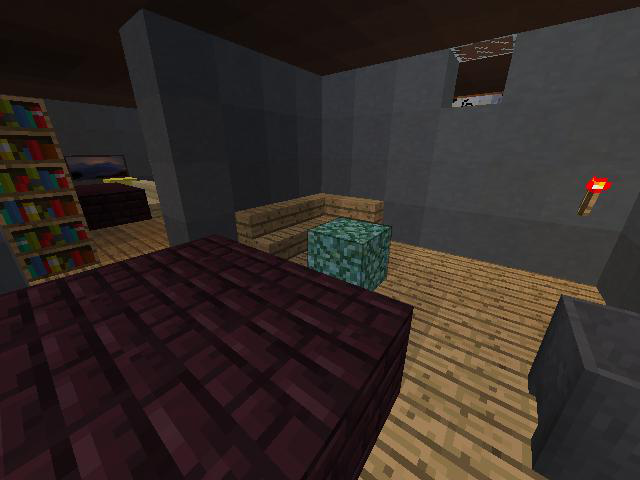

no torch near by a bookshelf <eos> <eos> a <eos>
torch is not near a bookshelf <eos> <pad> <pad>
0 0


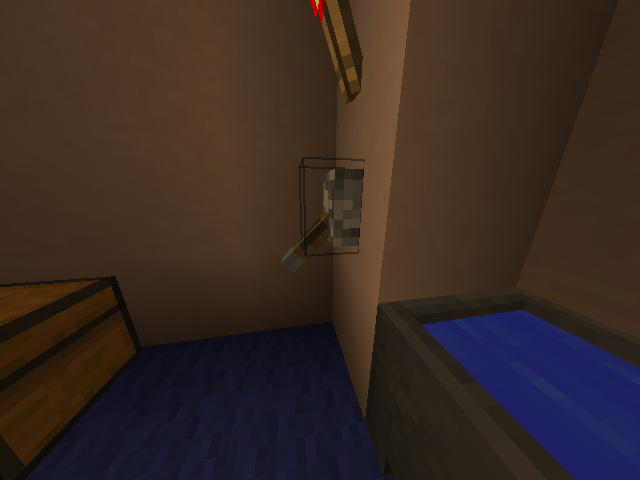

no window near by a fire <eos> <eos> a victim
no window close to a fire <eos> <pad> <pad>
0 0


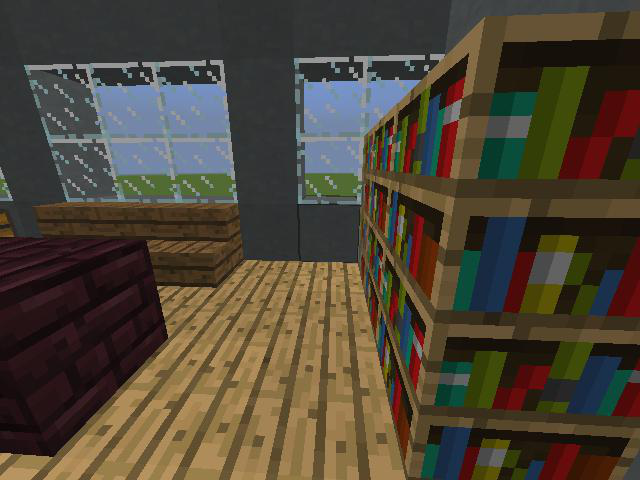

can locate no <eos> <eos> <eos> a switch <eos> <eos>
no switch can be located <eos> <pad> <pad> <pad>
2 2


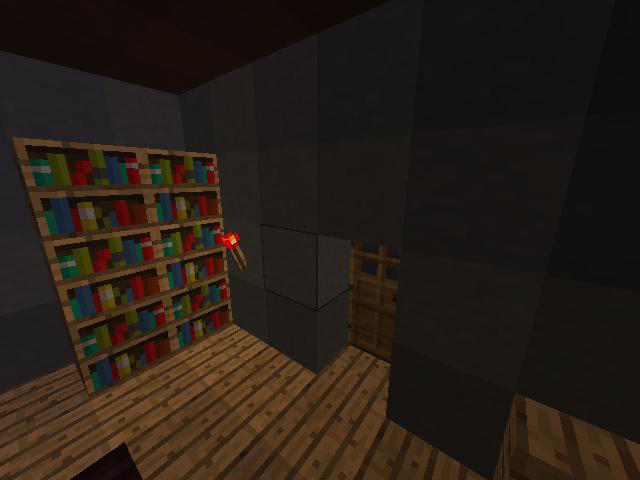

switch could not be found <eos> <eos> <eos> a <eos>
switch could not be identified <eos> <pad> <pad> <pad>
0 0


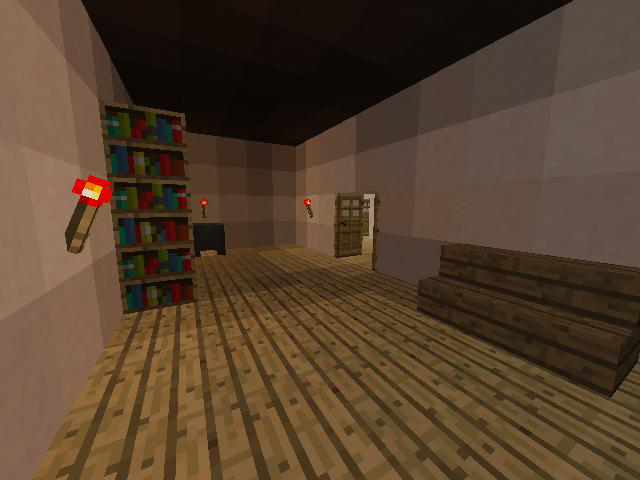

no torch near by a bookshelf <eos> <eos> a <eos>
torch is not near a bookshelf <eos> <pad> <pad>
0 0


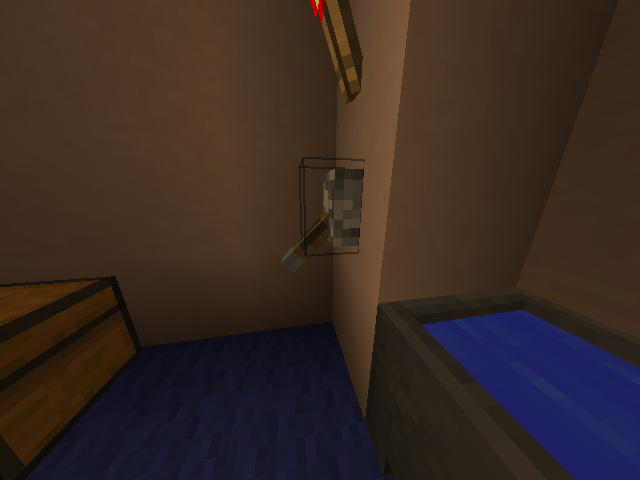

bookshelf could not be found <eos> <eos> <eos> a <eos>
not in front <eos> <pad> <pad> <pad> <pad> <pad>
0 0


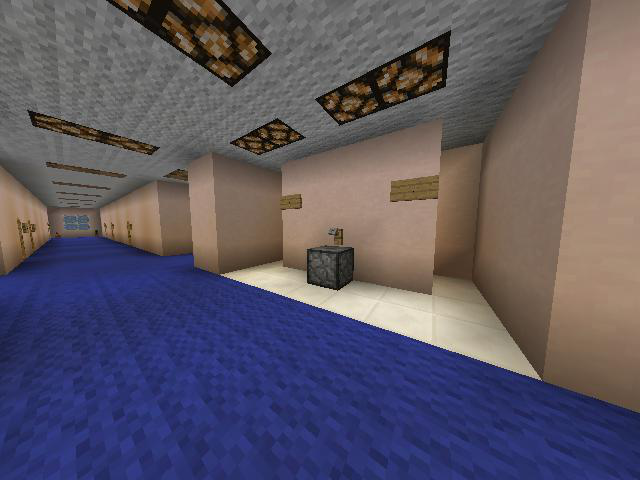

switch could not be found <eos> <eos> <eos> a <eos>
switch could not be identified <eos> <pad> <pad> <pad>
0 0


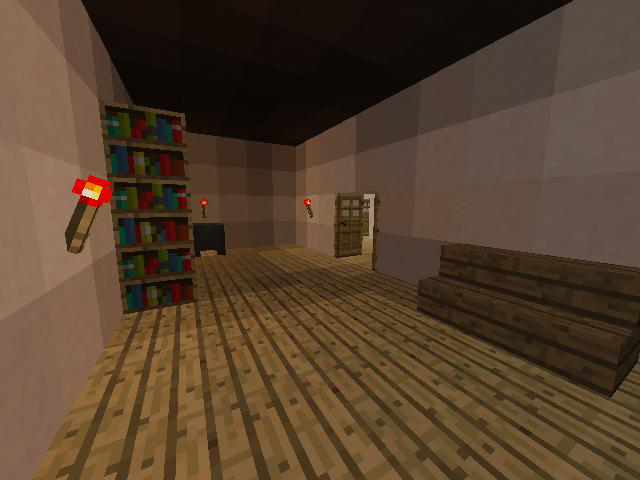

window could not be found <eos> <eos> <eos> a <eos>
no <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
0 0


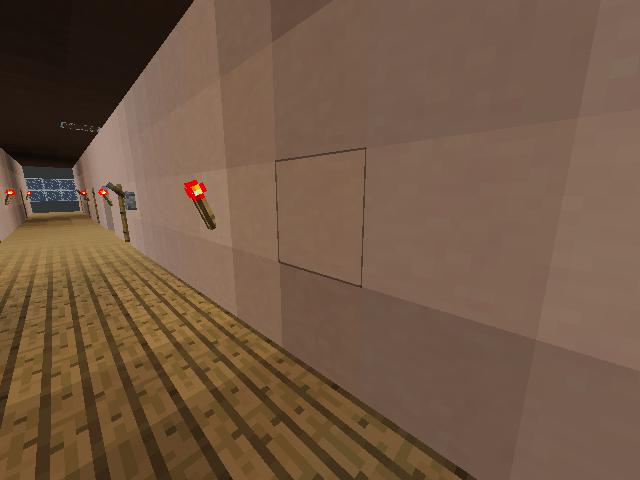

furniture close to victim <eos> <eos> <eos> a <eos> <eos>
yes <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
1 1


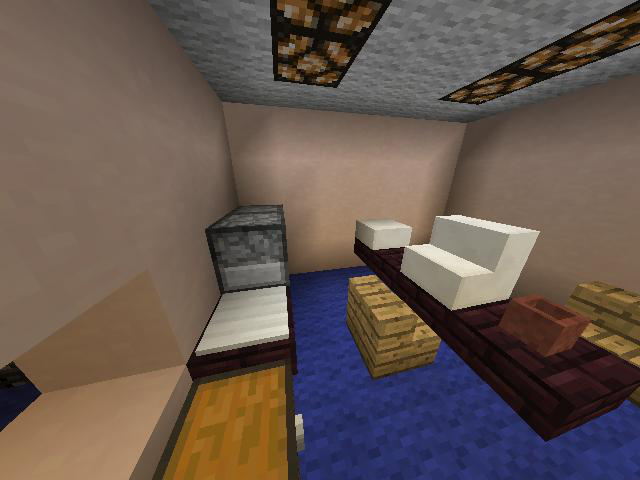

In [64]:
for _ in range(10):
    i = random.randint(0, 63)
    print(" ".join([mappings["vocab"]["wid_2_word"][str(wid)] for wid in eval_preds["des_preds"][i]][:10]))
    print(" ".join([mappings["vocab"]["wid_2_word"][str(wid)] for wid in eval_preds["des_true"][i]][1:10]))
    print(eval_preds["vqa_preds"][i], eval_preds["vqa_true"][i])
    display(transforms.ToPILImage()(eval_preds["imgs"][i]))

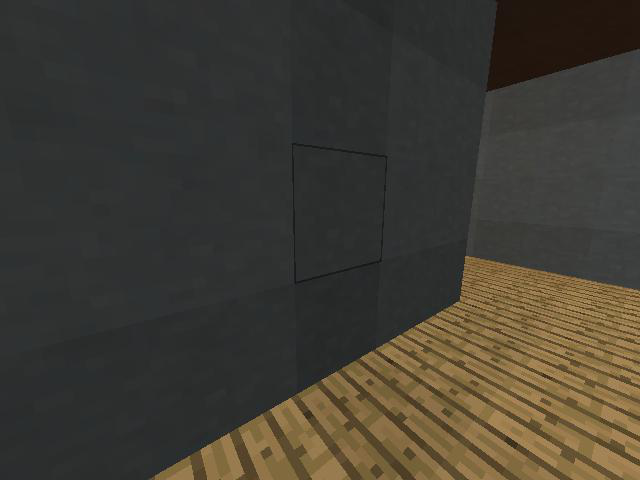